In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import string
import shutil
from tensorflow.keras import layers, losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

# Already downloaded
dataset_dir = os.path.join(os.path.dirname("aclImdb_v1"), 'aclImdb')

In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read()) # Leemos un fichero cualquiera

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
batch_size = 32
seed = 42

raw_train_data_source = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
raw_val_data_source = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
raw_test_data_source = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.


In [9]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


In [10]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


In [11]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_data_source.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [13]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_data_source))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_data_source.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [24]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [14]:
train_data_source = raw_train_data_source.map(vectorize_text)
val_data_source = raw_val_data_source.map(vectorize_text)
test_data_source = raw_test_data_source.map(vectorize_text)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_data_source = train_data_source.cache().prefetch(buffer_size=AUTOTUNE)
val_data_source = val_data_source.cache().prefetch(buffer_size=AUTOTUNE)
test_data_source = test_data_source.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
embedding_dim = 16

In [17]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [18]:
#Función de pérdida y optimizador
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))


In [27]:
# Entrenamos al modelo
epochs = 30
history = model.fit(
    train_data_source,
    validation_data=val_data_source,
    epochs=epochs)


Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.2190 - binary_accuracy: 0.9193 - val_loss: 0.2882 - val_binary_accuracy: 0.8810
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2080 - binary_accuracy: 0.9260 - val_loss: 0.2863 - val_binary_accuracy: 0.8820
Epoch 3/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1963 - binary_accuracy: 0.9298 - val_loss: 0.2858 - val_binary_accuracy: 0.8830
Epoch 4/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1878 - binary_accuracy: 0.9346 - val_loss: 0.2857 - val_binary_accuracy: 0.8822
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1792 - binary_accuracy: 0.9369 - val_loss: 0.2867 - val_binary_accuracy: 0.8836
Epoch 6/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1703 - binary_accuracy: 0.9413 - val_loss: 0.2884 - val_binary_accuracy: 0.8848
Epoch 7/30
625/625 [==============================] - 2s 3ms/ste

In [28]:
# Evaluamos el modelo con los valores de test
loss, accuracy = model.evaluate(test_data_source)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.5313 - binary_accuracy: 0.8463
Loss:  0.5313090682029724
Accuracy:  0.8463199734687805


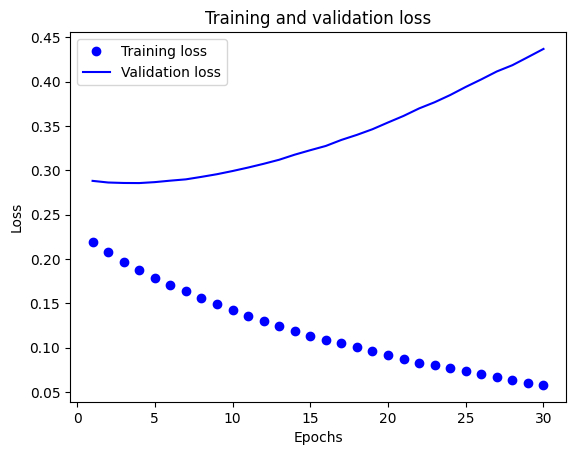

In [29]:
# Gráfico de pérdida
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


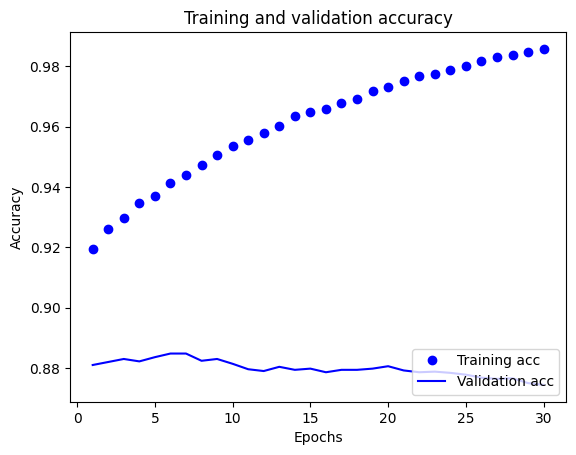

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [30]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_data_source`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_data_source)
print(accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.5313 - accuracy: 0.8463
0.8463199734687805


In [31]:
#Evaluamos el modelo
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
    "1/10 acting"
]

export_model.predict(examples)

1/1 [==============================] - 0s 136ms/step


array([[0.7034678 ],
       [0.32001823],
       [0.23907572],
       [0.14314598]], dtype=float32)